In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
import os


SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

fig_labels = ['$S$', '$b_e$ (pA)', '$E_{L,i}$ (mV)', '$E_{L,e}$ (mV)', '$T$ (ms)']

# Plotting the PSDs when varying the parameters


In [7]:
def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings
    Author: ahwillia from StackOverflow.
    Obtained from:
    https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
    
    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [8]:
# First let's just clean the data in a way that I want. I will re-obtain 4 .npy files (mean_e, std_e, 
# mean_i, std_i) with first 6 elements the same.

folder_chunks = './data/psds/'

i = 0
first_cols = 6
total_cols = 100002
cols_psd = int((total_cols - first_cols) / 4)
for chunk in os.scandir(folder_chunks):
    
    full_file = np.load(chunk.path)
    
    idx_mean_e = cols_psd + first_cols
    temp_mean_e = full_file[:, 0: idx_mean_e]
    
    idx_std_e = idx_mean_e + cols_psd
    temp_std_e = np.concatenate((full_file[:, 0:first_cols], full_file[:, idx_mean_e: idx_std_e]), axis=1)
    
    idx_mean_i = idx_std_e + cols_psd
    temp_mean_i = np.concatenate((full_file[:, 0:first_cols], full_file[:, idx_std_e: idx_mean_i]), axis=1)
    
    idx_std_i = idx_mean_i + cols_psd
    temp_std_i = np.concatenate((full_file[:, 0:first_cols], full_file[:, idx_mean_i: idx_std_i]), axis=1)
    
    if i == 0:
        mean_e = temp_mean_e
        std_e = temp_std_e
        mean_i = temp_mean_i
        std_i = temp_std_i
    
    else:
        mean_e = np.concatenate((mean_e, temp_mean_e), axis=0)
        std_e = np.concatenate((std_e, temp_std_e), axis=0)
        mean_i = np.concatenate((mean_i, temp_mean_i), axis=0)
        std_i = np.concatenate((std_i, temp_std_i), axis=0)
        
    i += 1

# First 5 elements are: S_vals, b_vals, E_L_i_vals, E_L_e_vals, T_vals
# 6th element is maxFR

f_sampling = 10000  # time in seconds, f_sampling in Hz
N = int(5000 / 0.1)
frq = np.fft.fftfreq(N, 1/f_sampling)
frq = frq[frq > 0]

print(mean_e.shape)
print(frq.size)

(88, 25005)
24999


## First effect of varying b

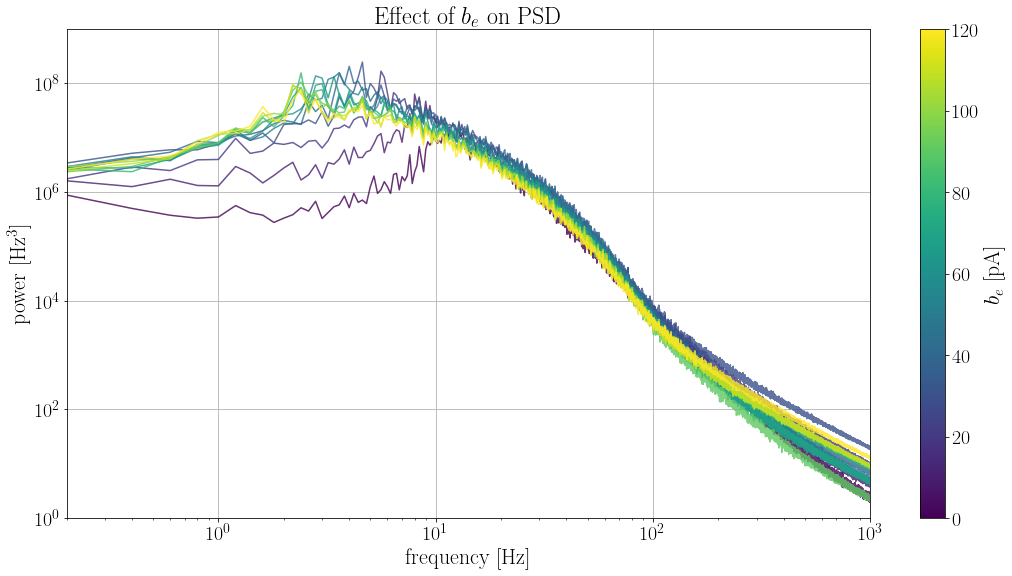

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
steps = 25
bs = np.round(np.linspace(0, 120, steps), 3)[::2]

cmap = matplotlib.cm.get_cmap('viridis')

rgba = cmap(0.5)
for b in bs:
    idxs = np.logical_and(mean_e[:, 0] == 0.3, mean_e[:, 1] == b)
    psd = mean_e[idxs, 6:][0]  # The 0 is to get rid of repeated and extra dimension
    std = std_e[idxs, 6:]
    b_norm = b / 120
    plt.loglog(frq, psd, c=cmap(b_norm), alpha=0.8)

plt.xlabel('frequency [Hz]')
#plt.xlabel(r'$\nu_E [Hz]$')
plt.ylabel('power [Hz$^3$]')  
plt.xlim(np.amin(frq[frq > 0]), 1000)
plt.ylim(10e-1, 10e8)
plt.grid()

norm = matplotlib.colors.Normalize(vmin=0,vmax=120)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm)
plt.title('Effect of $b_e$ on PSD')
cb.ax.set_ylabel('$b_e$ [pA]')
fig.savefig('./figures/article_figures/PSD_withb.pdf')
plt.show()

## Then effect of varying S both in AI and UD states

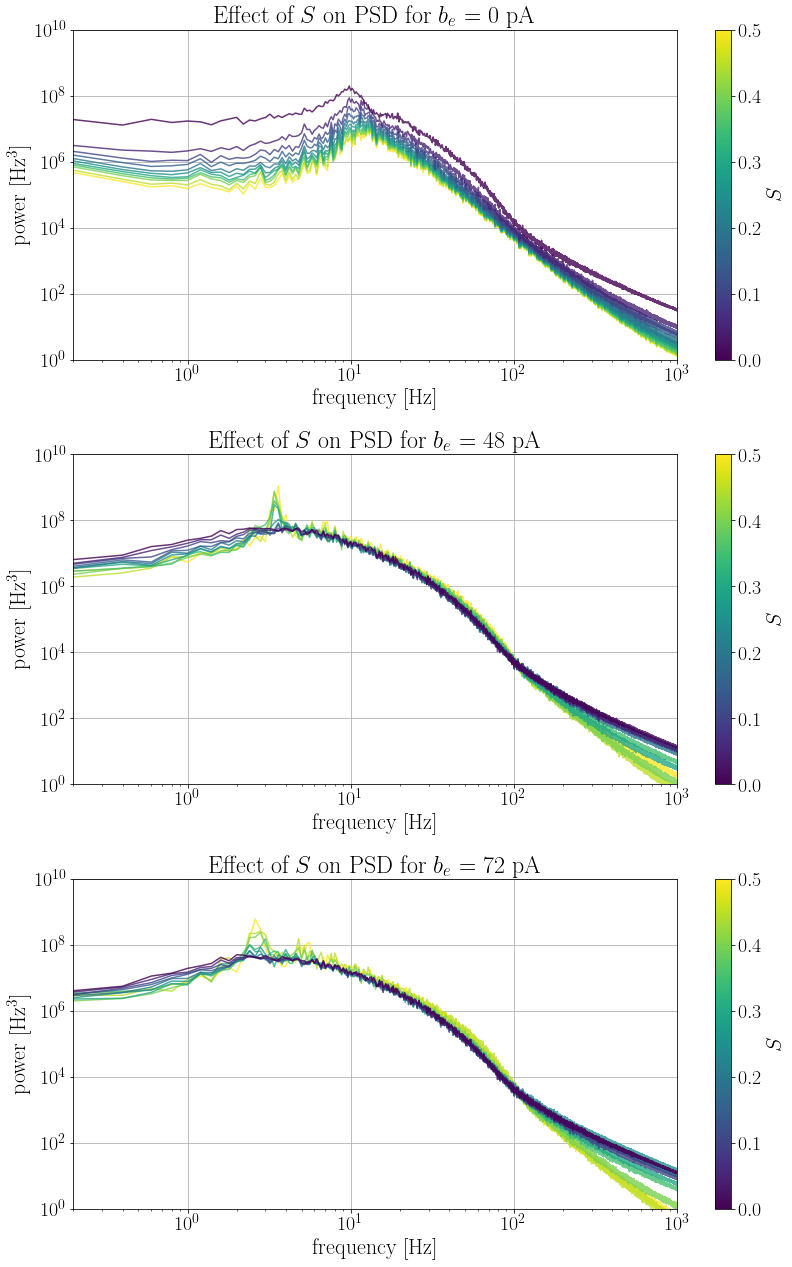

In [124]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
steps = 21
S = np.round(np.linspace(0.5, 0, steps), 3)[::2]

cmap = matplotlib.cm.get_cmap('viridis')
for i, b in enumerate([0.0, 48.0, 72.0]):
    for s in S:
        idxs = np.logical_and(mean_e[:, 0] == s, mean_e[:, 1] == b)
        psd = mean_e[idxs, 6:][0]  # The 0 is to get rid of repeated and extra dimension
        std = std_e[idxs, 6:]
        b_norm = s / 0.5
        axes[i].loglog(frq, psd, c=cmap(b_norm), alpha=0.8)

    axes[i].set_xlabel('frequency [Hz]')
    #plt.xlabel(r'$\nu_E [Hz]$')
    axes[i].set_ylabel('power [Hz$^3$]')  
    axes[i].set_xlim(np.amin(frq[frq > 0]), 1000)
    axes[i].set_ylim(10e-1, 10e9)
    axes[i].set_title('Effect of $S$ on PSD for $b_e$ = ' + str(int(b)) + ' pA')
    axes[i].grid()

    norm = matplotlib.colors.Normalize(vmin=0,vmax=0.5)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = plt.colorbar(sm, ax=axes[i])
    cb.ax.set_ylabel('$S$')
    

plt.tight_layout()
fig.savefig('./figures/article_figures/Fig4Supp.pdf')
plt.show()